# Exercise Sheet No. 3

---

> Machine Learning for Natural Sciences, Summer 2021, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Deadline: 03.05.2021, 2pm

---

**Topic**: This exercise sheet will focus on linear algebra, precision, recall and feature reduction. You will continue to use ``numpy`` methods.

## 3.1 Distance function computation

For many feature descriptors and also for a specific implementation of the nearest neighbor classier, the Euclidean mutual distance between a set of points must be computed. This serves as a measure on how two points are distinct or how far apart they are in Euclidean space. We will make use of this very often in the future. Therefore this exercise focus on an efficient implementation using numpy. You should gain a better unstanding of `numpy` methods.

**3.1.1** Implement this in a python function ``dist_loop(A,B)``, which computes the Euclidean distance between all instances between two sets of points $A \subset \mathbb{R}^{D}$ and $B \subset \mathbb{R}^{D}$. The input should be two matrices of shape $N \times D$ and $M \times D$. Do this by using explicit python loops to find the distance $d_{ij} = || a_{i} - b_{j} ||$ between two points $a_{i} \in A$ and $b_{i} \in B$. The output should be a $N \times M$ distance matrix. For the calculation of the Euclidean distance you might want to use ``numpy.square()``, ``numpy.sum()`` and ``numpy.sqrt()``.

In [1]:
import numpy as np
from numpy import random
import sys
n = 500
m = 1000
d = 3
A_data = np.reshape(random.rand(n*d),(n,d))
B_data = np.reshape(random.rand(m*d),(m,d))
print("A shape:", A_data.shape, "B shape:", B_data.shape)

A shape: (500, 3) B shape: (1000, 3)


In [2]:
def dist_loop(A,B):
    # YOUR CODE HERE
    results = np.zeros((A.shape[0], B.shape[0]))
    dist = lambda x,y: np.sqrt(np.sum((x-y)**2,axis=-1))
    
    for x_idx, x in enumerate(A):
        for y_idx, y in enumerate(B):
            results[x_idx][y_idx] = dist(x,y)
    
    return results

In [3]:
dist_loop_test = dist_loop(A_data,B_data)
dist_loop_test.shape

(500, 1000)

**3.1.2** Since loops are rather slow in python, and more efficient code is required for numeric operations, write a second
python function ``dist_vec(A,B)`` for computing the distance function which relies
on vectorization from ``numpy`` methods. Consult https://www.safaribooksonline.com/library/view/python-for-data/9781449323592/ch04.html and https://softwareengineering.stackexchange.com/questions/254475/how-do-i-move-away-from-the-for-loop-school-of-thought for information on how to do this. 

Tip: There is more than one way to do it. For the most straightforward answer, you need to add an additional dimension to `np.arrays` via for example `expand_dims`. If two `np.arrays` do not have matching shape they are then automatically broadcasted by repeating their respective element along the axis in question. Beside broadcasting, also the [indexing rules](https://numpy.org/doc/stable/reference/arrays.indexing.html) (required for 3.2, 3.3) of `numpy` help with vectorization to avoid pyhton loops. You must not use ``scipy`` or its methods for this task!

In [4]:
def dist_vec(A,B):
    # YOUR CODE HERE
    """
    dist = lambda x,B: np.sum(np.abs(x-B)**2,axis=-1)
    results = np.zeros((A.shape[0], B.shape[0]))
    
    for x_idx, x in enumerate(A):
        results[x_idx] = dist(x, B)
    """
    return np.sqrt(np.sum((A[:,None] - B)**2,axis=-1))

Check that the two function return the same result. And check the output shape of the results.

In [5]:
result_loop = dist_loop(A_data,B_data)
result_vec = dist_vec(A_data,B_data)
result_vec_shape = result_vec.shape # Check shape of result_loop
result_loop_shape = result_loop.shape # Check shape of result_vec
# YOUR CODE HERE
result_loop == result_vec
# check with np.linalg.norm()

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Now compare the run times of the two implementations using jupyter's ``%timeit`` command or pythons ``time``. How much faster is the vectorized version?

In [6]:
# measure time for loop
%timeit result_loop = dist_loop(A_data,B_data)
# measure time for loop
%timeit result_vec = dist_vec(A_data,B_data)

5.71 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.5 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# speed_up_factor = 1 # A rough estimation is okay.
# since 1s = 1000ms
speed_up_factor = 4290 / 19.8

Note: It is absolutely critical that you understand vectorization, and with this the indexing and broadcasting methods of numy. Not only do we need the fast performance, but also all deep learning frameworks are based on array or tensor operations just like you used with ``numpy``.

In [8]:
assert callable(dist_loop)

In [9]:
assert callable(dist_vec)

In [10]:
assert result_loop is not None
assert result_vec is not None

In [11]:
assert result_vec_shape is not None
assert result_loop_shape is not None

In [12]:
assert speed_up_factor > 0

## 3.2 Precision-Recall Curves

In this exercise, we use sklearn's digits dataset for an image retrieval experiment. Given any image
from this dataset as a query, your algorithm shall find all similar images, where we define similarity
by "contains the same digit". Of course, only the features (i.e. the pixel values of the images) may be
used for similarity search. The known labels only serve for testing the quality of the search result. This approach measures how clustered the calsses are in a defined feature space (i.e. pixels). Start loading the dataset.

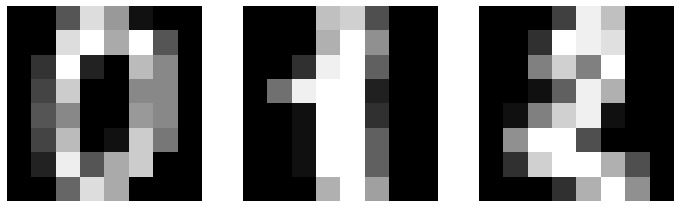

[0 1 2]


In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# read and prepare the digits data
digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
# Show digits
fig = plt.figure(figsize = (10,3))
plt.gray()
plt.subplot(1,3,1); plt.axis('off')
plt.imshow(images[0])
plt.subplot(1,3,2); plt.axis('off')
plt.imshow(images[1])
plt.subplot(1,3,3); plt.axis('off')
plt.imshow(images[2])
fig.tight_layout(); plt.show()
print(target[:3])

Define dissimilarity by the Euclidean distance between pixel values:

$d(X_i,X_{i'} ) = || X_i - X_{i'}||^2_2$

To effciently compute these distances, you should use vectorization from exercise 3.1. Let $D$
be the full dissimilarity matrix, i.e. $D_{i i'} = d(X_i,X_{i'})$. An ``np.argsort()`` of row $D_i$ now gives the similarity ordering of all digits relative to query digit $X_i$. The response sets $S_{im}$ consist of the $m$ nearest instances to query $X_i$ (including $X_i$ itself), with $m$ running over all values from 1 to $N$.

Note: If you didn't manage to solve 3.1 you can now use `scipy.spatial.distance.cdist`. But you do not get points for this solution in 3.1.

In [14]:
dist_xx = dist_vec(data, data) # Compute distance matrix from data (data = digits["data"]), do not change the data here!
resp_Sim = np.argsort(dist_xx, axis=1) # Response set that holds indices (i,m) for X_i-X_m

The positive class is defined by the instances having the same label as the query, i.e. $Y_{i'} = Y_i$, and
$N_i = \# \{i' \in 1,\dots,N : Y_{i'} = Y_i \}$ is the total number of positives. Each response set defines a pair ($\text{precision}_{im}$; $\text{recall}_{im}$) as:

$\text{precision}_{im} = \frac{\text{TP}_i(m)}{\text{TP}_i(m) + \text{FP}_i(m)}$,      $\text{recall}_{im} = \frac{\text{TP}_i(m)}{N_i}$

where $\text{TP}_i(m) = \# \{i' \in S_{im} : Y_i = Y_{i'}\}$ and $\text{FP}_i(m) = \# \{i' \in S_{im} : Y_i \neq Y_{i'}\}$ are the number of true and false positives in $S_{im}$. Compute the $N\times N$ precision matrix $P$ and recall matrix $R$ whose elements are the precision resp. recall values from these pairs, i.e. $P_{im} = \text{precision}_{im}$ and $R_{im} = \text{recall}_{im}$. 

Tip: You can use broadcasting with `np.expand_dims(axis)` and `np.cumsum` for vectorization. You may use indexing and indexing via boolean arrays, too. 

In [15]:
true_positives = np.cumsum(target[:, None] == target[resp_Sim], axis=-1) # as TP_i(m) of shape (1797, 1797)
false_positives = np.cumsum(target[:, None] != target[resp_Sim], axis=-1) #  as FP_i(m) of shape (1797, 1797)
total_positives = np.sum(target[:, None] == target[resp_Sim], axis=-1) # as N_i of shape (1797,)

# Calculate the NxN precision and recall matrices
Pim = true_positives / (true_positives + false_positives) # of shape (1797, 1797)
Rim = true_positives / total_positives # of shape (1797, 1797)

For each digit class $k \in \{0,\dots,9\}$, compute $\bar{P}_k$ and $\bar{R}_k$ as the average of the rows of $P$ and $R$ referring to class $k$, i.e. where $Y_i = k$, with $m$ as the the free parameter.

In [16]:
Pk_m = np.asarray([Pim[np.where(target==i)].mean(axis=0) for i in range(10)]) # averaged Pim of shape (10,1797)
Rk_m = np.asarray([Rim[np.where(target==i)].mean(axis=0) for i in range(10)]) # averaged Rim of shape (10,1797)

Plot the resulting precision/recall curves (using $m$ as the free parameter) and determine the area-under-curve (AUC) for each $k$. Do not use the implementation of ``sklearn`` in this task. This means you have to plot Recall vs. Precision for each class.

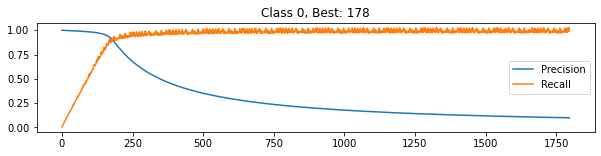

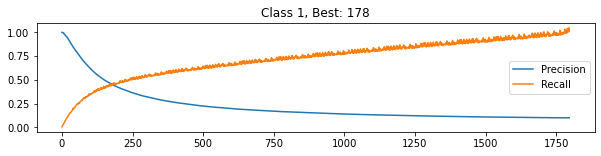

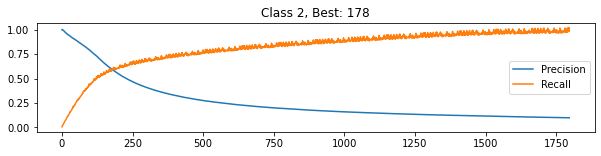

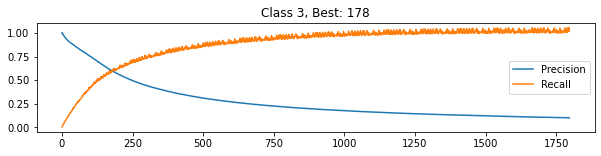

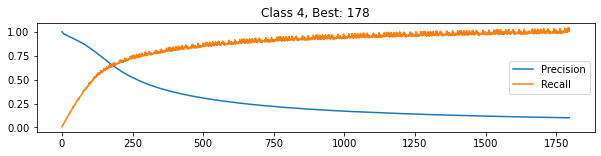

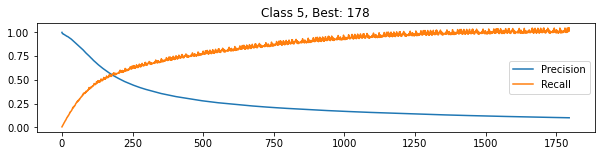

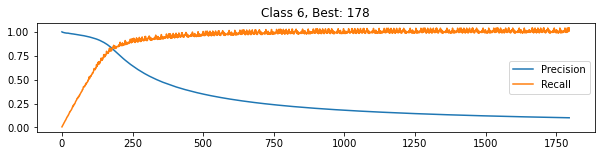

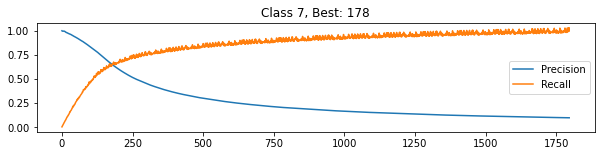

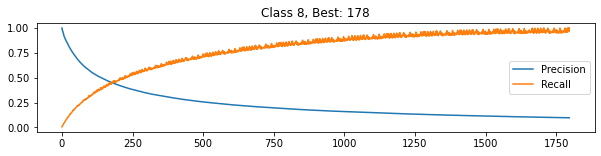

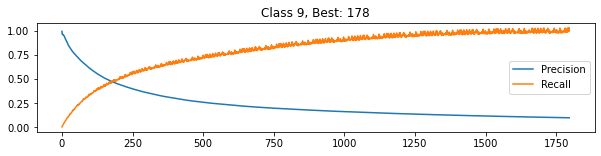

In [17]:
def auc_precision_recall(precision,recall):
    # precision is P(m) for a specific class of shape (1797,)
    # recall is R(m) for a specific class of shape (1797,)
    return np.abs(np.trapz(y=precision, x=(recall)))

# Get Area under curve with auc_precision_recall()
AUC = auc_precision_recall(Pk_m, Rk_m) # List of AUC for each number 0,...,9 via auc_precision_recall()


"""
fig, axes = plt.subplots(nrows=5, ncols=2)
plot_index = 0
for ax in axes.flatten():
    precision = Pk_m[k]
    recall = Rk_m[k]
    
    ax.plot(range(0, target.shape[0]), precision, label="Precision")
    ax.plot(range(0, target.shape[0]), recall, label="Recall")
"""

# Plot the Precision-Recall Curves

for k in range(0, 10):
    precision = Pk_m[k]
    recall = Rk_m[k]
    plt.figure(figsize=(10,2))
    plt.plot(range(0, target.shape[0]), precision, label="Precision")
    plt.plot(range(0, target.shape[0]), recall, label="Recall")
    best_m = np.argmin(np.abs(Pk_m[k] - Rk_m[k]))
    # plt.vline(best_m, y_min=0, y_max=1, label="Best {best_m}")
    plt.title(f"Class {k}, Best: {best_m}")
    plt.legend()
    plt.show()

In [18]:
assert dist_xx is not None
assert dist_xx.shape[0] == 1797 and dist_xx.shape[1] == 1797

In [19]:
assert resp_Sim is not None
try:
    assert np.all(resp_Sim[0:2,0:2] == np.array([[0,877],[1,93]]))
except:
    print("resp_Sim should contain indices that give a similarity ordering, please do not shuffle the data for grading tests.")

In [20]:
assert true_positives is not None
try:
    assert true_positives[0,0] == 1 and true_positives[0,-1] == 178
except:
    print("As a sanity test, the first entry should be always 1 and the lasts equals the number of class labels for that digit.")
    print("Number of 0's:", np.sum(target == 0))

In [21]:
assert false_positives is not None
try:
    assert false_positives[0,0] == 0 and false_positives[0,-1] == 1619
except:
    print("As a sanity test, the first entry should be always 0 and the last equals the number of other class labels for that digit.")
    print("Number of classes;",len(target) ,"number of 0's:", np.sum(target == 0), "means: ", len(target) - np.sum(target == 0) )

In [22]:
assert total_positives is not None

In [23]:
assert Pim is not None

In [24]:
assert Rim is not None

In [25]:
assert Pk_m is not None
try:
    assert Pk_m[0,0] - 1 < 0.01 and Pk_m[0,-1] - 0.09905 < 0.01
except:
    print("For closest neighbours we expect high precision, and low precision for all neighbours considered")

In [26]:
assert Rk_m is not None

In [27]:
assert AUC is not None
try:
    assert (AUC[0] - 0.9450) < 0.1 and (AUC[-1] - 0.4825) < 0.1
except:
    print("We expect a bad AUC for similar digits like 9,8,6. Interestingly '0' is well clustered with AUC of ca. 0.95")

### 3.3 PCA and LDA

Now we will try to reduce the number of features or pixels to two and re-test the precision/recall curves from exercise 3.2.

As a first approach we try an unsupervised reduction of features, namely via Principle Component Analysis (PCA). The task is to use `scikit-learn`'s implementation of the PCA to reduce the number of pixels to two and then to make a scatter plot of the new features, where the color of each point represents the digits number.  Which property should this scatterplot have in order for the new features to be especially suitable for similarity search?

In [28]:
from sklearn.decomposition import PCA
new_features_pca = PCA(n_components=2).fit_transform(data) # Make new features of shape (1797, 2)

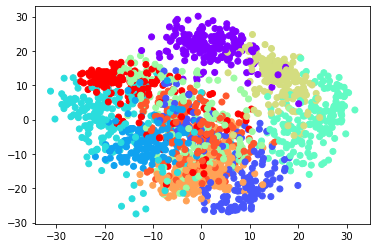

In [29]:
plt.scatter(new_features_pca[:, 0], new_features_pca[:, 1], c=target, cmap="rainbow")

Repeat the experiment from above for new features but this time with a supervised feature reduction. We use the Linear Discriminant Analysis (LDA), which is linear too but seeks to fit class conditional densities to the data and using Bayes’ rule. You can use the `scikit-learn`'s implementation of LDA. Repeat the step above and make a scatter plot of the new features, where the color of each point represents the digits number. What is the difference? Which method is better suited for dissimilarity search?

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
new_features_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(data, target) # Make new features of shape (1797, 2)

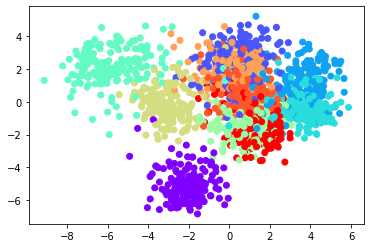

In [31]:
plt.scatter(new_features_lda[:, 0], new_features_lda[:, 1], c=target, cmap="rainbow")

Now you have to repeat the steps of 3.2. To do so, simply wrap the solution of 3.2 in a function as indicated below.

Note: If you didn't solve 3.2, you can still answer the question based the plots above. The function below and the PCA/LDA recall curves are not graded.

In [32]:
def make_precision_recall_distance(X,y):
    dist_xx = dist_vec(X, X) # Compute distance matrix from data (data = digits["data"]), do not change the data here!
    resp_Sim = np.argsort(dist_xx, axis=1) # Response set that holds indices (i,m) for X_i-X_m
    
    true_positives = np.cumsum(y[:, None] == y[resp_Sim], axis=-1) # as TP_i(m) of shape (1797, 1797)
    false_positives = np.cumsum(y[:, None] != y[resp_Sim], axis=-1) #  as FP_i(m) of shape (1797, 1797)
    total_positives = np.sum(y[:, None] == y[resp_Sim], axis=-1) # as N_i of shape (1797,)

    # Calculate the NxN precision and recall matrices
    Pim = true_positives / (true_positives + false_positives) # of shape (1797, 1797)
    Rim = true_positives / total_positives # of shape (1797, 1797)
    
    Pk_m = np.asarray([Pim[np.where(y==i)].mean(axis=0) for i in range(10)]) # averaged Pim of shape (10,1797)
    Rk_m = np.asarray([Rim[np.where(y==i)].mean(axis=0) for i in range(10)]) # averaged Rim of shape (10,1797)
    
    return Pk_m, Rk_m

Now plot the precision-recall curves for the dissimilarity by the Euclidean distance of the new features for the PCA and LDA. What do you observe? Does it improve with respect to the full digits?

In [33]:
def plot_precision_recall(Pk_m, Rk_m, y):
    for k in range(0, 10):
        precision = Pk_m[k]
        recall = Rk_m[k]
        
        plt.figure(figsize=(10,2))
        plt.plot(range(0, y.shape[0]), precision, label="Precision")
        plt.plot(range(0, y.shape[0]), recall, label="Recall")
        best_m = np.argmin(np.abs(Pk_m[k] - Rk_m[k]))
        # plt.vline(best_m, y_min=0, y_max=1, label="Best {best_m}")
        plt.title(f"Class {k}, Best: {best_m}")
        
        plt.legend()
        plt.show()

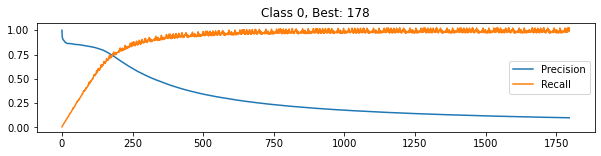

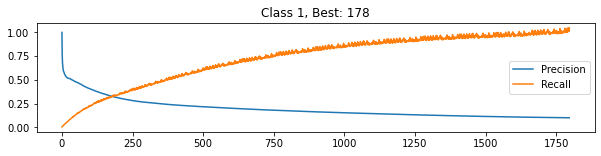

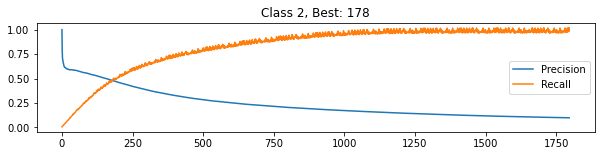

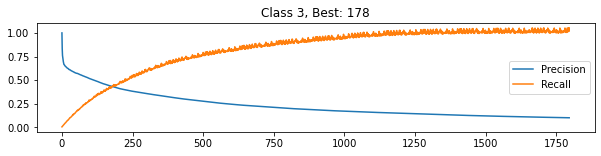

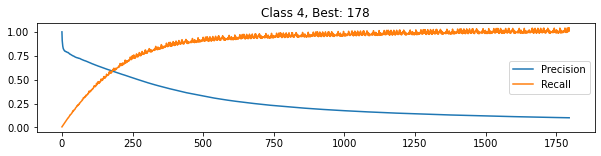

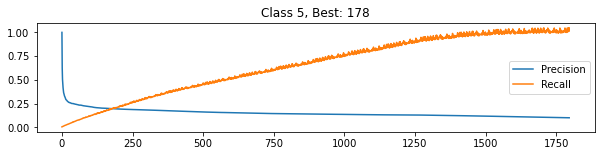

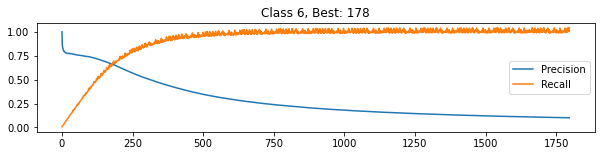

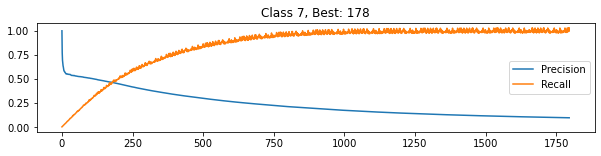

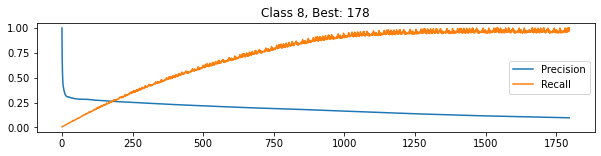

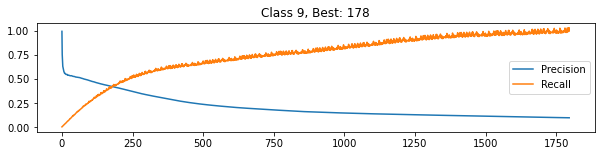

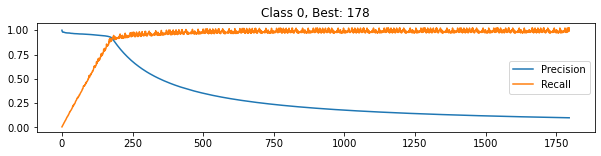

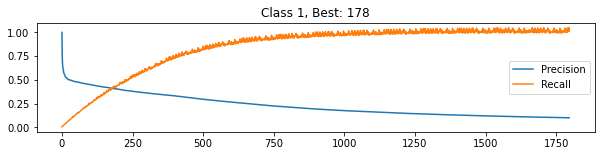

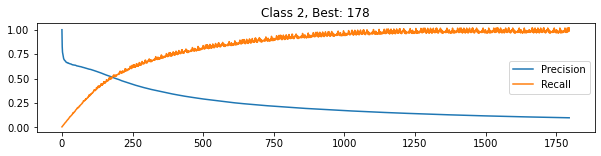

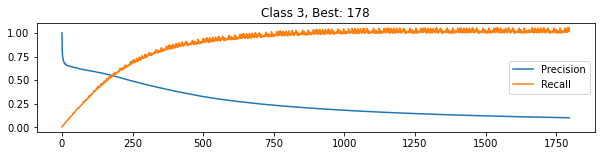

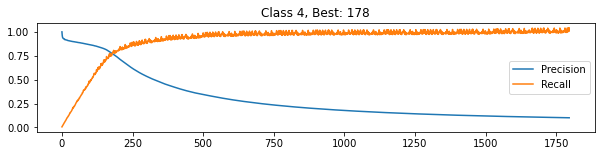

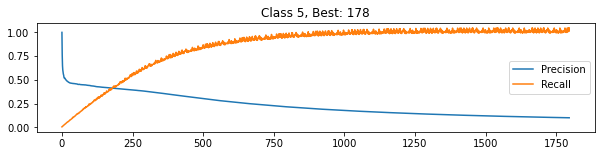

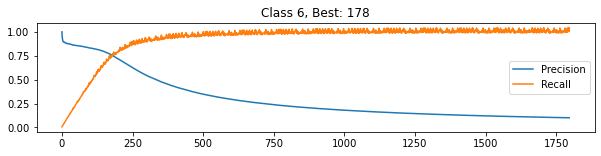

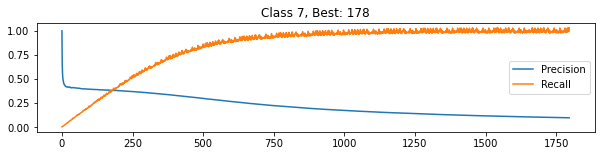

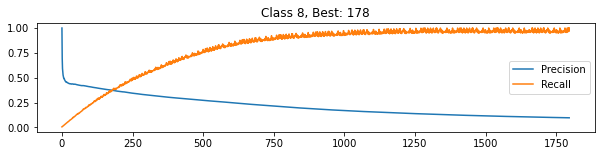

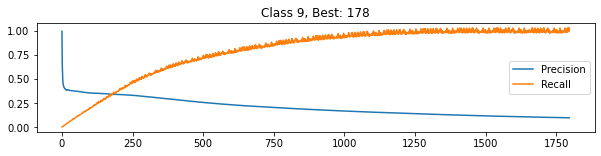

In [34]:
pkm_pca, rkm_pca = make_precision_recall_distance(new_features_pca, target)
pkm_lda, rkm_lda = make_precision_recall_distance(new_features_lda, target)

# and now plot
plot_precision_recall(pkm_pca, rkm_pca, target)
plot_precision_recall(pkm_lda, rkm_lda, target)

In [35]:
linear_reduction_answer = True # Get better: True , get worse: False
"""
Explanation: The curves tend to go down faster for precision after applying PCA/LDA.
"""

'\nExplanation: The curves tend to go down faster for precision after applying PCA/LDA.\n'

In [36]:
assert new_features_pca is not None

In [37]:
assert new_features_lda is not None

In [38]:
assert isinstance(linear_reduction_answer,bool)